In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker  ## special scaling stuff
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import pickle
import OFM_postprocess_scripts as post
from importlib import reload

In [2]:
# retrieve files from saved pickles
model_vers = 'v4'
exps_s = post.read_experiments_from_pickle(f'data_output/experiment_sens_rev2_model{model_vers}.pickleobject')
exps_p = post.read_experiments_from_pickle(f'data_output/experiment_pols_model{model_vers}.pickleobject')


# Sensitivity: Post-processing

In [3]:
# extract relevant information from pickled experiment object
# reload(post)
meta_s = pd.DataFrame.from_dict(exps_s.results_metadata, orient='index')
results_s: pd.DataFrame = post.add_extra_metrics(exps_s)

# invert the policy inputs to be relative again (instead of machine-focused)
policy_inputs = dict((v, k) for k, v in exps_s.p_flightbans_map.items())  # inversion process

In [4]:
# collect indices of importance
# we do single-variate analysis first, with 0-day case?
d0_sens = results_s.loc[results_s.p_FlightBans == policy_inputs[0], :]
# d0_sens['infected_cum_pct'] = d0_sens['cum_infected'] / exps_s.c_pop_total  # TODO move this to function form

In [5]:

# we now isolate only the metric (cumulative infections) and relevant states: day, exp_id, policy/uncertainty
# trim out, mostly for readability
# d0_sens = d0_sens.loc[:, ['exp_id','elapsed_policy','imported','cum_infected', 'infected_total','infected_new']]
# get u_REff from meta
d0_meta = meta_s.loc[meta_s['p_FlightBans'] == policy_inputs[0], ['u_REff', 'u_NominalImports']]

d0_p_imported = d0_sens.pivot(values='imported', index='elapsed_policy', columns='exp_id')
d0_p_inf_cumulative = d0_sens.pivot(values='cum_infected', index='elapsed_policy', columns='exp_id')
d0_p_inf_current = d0_sens.pivot(values='infected_total', index='elapsed_policy', columns='exp_id')
# NB: seaborn prefers long data form for plotting!
# TODO: verify if the u_NominalImports scaling is correct!
# 50k-50k.. how to find?
# top-down search and bottom-up search?
threshold = 5000
d0_m_inf_current = post.add_threshold_time_search(df_to_search=d0_p_inf_current,
                                                  df_to_add=d0_meta,
                                                  threshold=threshold)

# make another m df for cumulative

In [6]:

# d0_mat_duration = d0_m_inf_current.pivot(values=f'duration_{threshold}', index='u_REff', columns='u_NominalImports')
# d0_mat_max = d0_m_inf_current.pivot(values='max', index='u_REff', columns='u_NominalImports')
# d0_mat_maxday = d0_m_inf_current.pivot(values='max_day', index='u_REff', columns='u_NominalImports')
# prolly can plot the max day and duration as a quadrant plot?

# Sensitivity: colour definition

In [7]:
# get categories from the experiment object
s_R_categories = exps_s.PARAMS_RAW['u_REff']
s_R_highlight = [1.1, 1.5, 2.0, 2.5, 3.0]  # hues to highlight
s_R_dull_colour = 'silver'  # hues to keep in background
s_R_ref_colour = {1.3: 'limegreen'}  # specific highlight for reference line (R=1.3)
s_R_highlight_all = sorted(s_R_highlight + [1.3])

# create custom palette for plotting
palette_s = cmr.get_sub_cmap('cmr.guppy_r', start=0., stop=1., N=len(s_R_highlight))  # make colourful palette
palette_s2 = dict((R, s_R_dull_colour) for R in s_R_categories)  # create all R-value categories in dull colours
palette_s2.update(
    dict(zip(s_R_highlight, palette_s.colors)))  #  change the highlighted categories to have bright colours
palette_s2.update(s_R_ref_colour)  # change the colour of the reference line

# Plot : sensitivity analysis, R on total infectious people

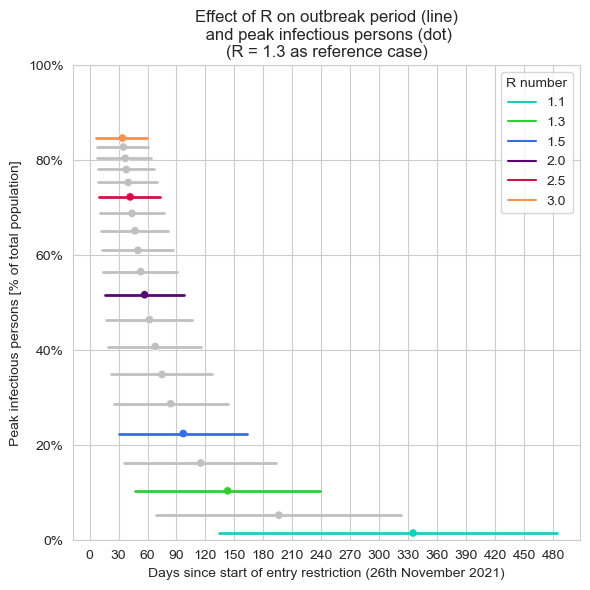

In [8]:
# let's try that map plot
# plot start and end, with central point as max day
# TODO: be careful that some inputs are floats and are not set to categorical form
# TODO: convert scaling to percentage of population?
plot_data = d0_m_inf_current.loc[(d0_m_inf_current['u_REff'] > 1.001) & (d0_m_inf_current['u_NominalImports'] == 15), :]
# ad hoc additions
plot_data = pd.melt(plot_data, id_vars=['u_REff', 'u_NominalImports', 'max_day', 'max'],
                    value_vars=['start_5000', 'end_5000'],
                    value_name='x')
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
# palette = cmr.get_sub_cmap('cmr.guppy_r', start=0.1, stop=0.9)
fig1, ax1 = plt.subplots(figsize=(6, 6))
plot_data = plot_data.rename(columns={'u_REff': 'R number',
                                      'u_NominalImports': 'Total Imports'},
                             )
plot_duration = sns.lineplot(plot_data, x='x', y='max', ax=ax1, palette=palette_s2,
                             hue='R number',  # style='Total Imports', dashes=dash_styles,
                             linewidth=2.)
plot_peaks = sns.scatterplot(plot_data, x='max_day', y='max', ax=ax1, palette=palette_s2, hue='R number', legend=False)
# rename axis
ax1.set_ylim(0, 1)
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{int(100 * x)}%')  # black magic
ax1.yaxis.set_major_formatter(ticks_y)
# ticks_x = ticker.FuncFormatter(lambda x, pos: f'{x/28}')
# ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_xticks(ticks=range(0, 501, 30))

ax1.set_ylabel('Peak infectious persons [% of total population]')
ax1.set_xlabel('Days since start of entry restriction (26th November 2021)')
ax1.set_title('Effect of R on outbreak period (line)\n '
              'and peak infectious persons (dot)\n'
              '(R = 1.3 as reference case)')

# get legend handles
h, l = ax1.get_legend_handles_labels()
h = [h[k] for k, a in enumerate(l) if float(a) in s_R_highlight_all]
ax1.legend(handles=h, labels=s_R_highlight_all, title='R number')

plt.tight_layout()
fig1.savefig(f'output_figures/plot_sens_R_peak_duration_{model_vers}.jpg', dpi=300)
# source: https://stackoverflow.com/questions/10171618/changing-plot-scale-by-a-factor-in-matplotlib

# Sensitivity: plot truncated wave plot for cumulative infected people

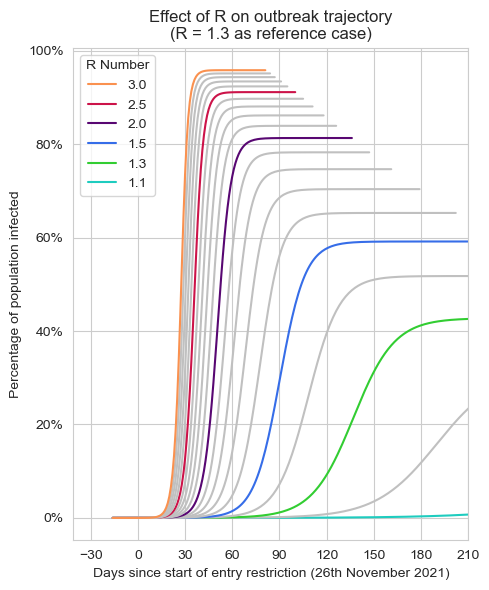

In [9]:
plot_data = d0_sens.loc[(d0_sens.u_NominalImports == 15) & (d0_sens.u_REff > 1.), :]
renamer = {'u_REff': 'R number',
           'cum_infected_pct': 'Percentage\ninfected',
           'elapsed_nominal': 'Days since reference date (26th Nov 2021)'}
plot_data = plot_data.rename(columns=renamer)

fig, ax4 = plt.subplots(figsize=(5, 6))
sns.lineplot(plot_data, x=renamer['elapsed_nominal'], y=renamer['cum_infected_pct'],
             hue=renamer['u_REff'], ax=ax4, palette=palette_s2)

ax4.set_xlim(None, 190)
ax4.set_xticks(range(-30, 211, 30))
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{int(x * 100)}%')
ax4.yaxis.set_major_formatter(ticks_y)

ax4.set_xlabel('Days since start of entry restriction (26th November 2021)')
ax4.set_ylabel('Percentage of population infected')
ax4.set_title('Effect of R on outbreak trajectory\n'
             '(R = 1.3 as reference case)')
h, l = ax4.get_legend_handles_labels()
h = [h[k] for k, a in enumerate(l) if float(a) in s_R_highlight_all]
ax4.legend(handles=reversed(h), labels=reversed(s_R_highlight_all), title="R Number")

# ax4.legend(handles=reversed(h), labels=reversed(l),
#            title='R number')

plt.tight_layout()
fig.savefig(f'output_figures/plot_sens, R on outbreak trajectory, {model_vers}.jpg', dpi=300)

# Sensitivity: plot for import scaling on outbreak peak timing

In [10]:
d0_infc2 = results_s.pivot(values='infected_total', index='elapsed_nominal', columns='exp_id')
threshold = 50000 # 50k
d0_infc2_m = post.add_threshold_time_search(df_to_search=d0_infc2,
                                            df_to_add=meta_s,
                                            threshold=threshold)


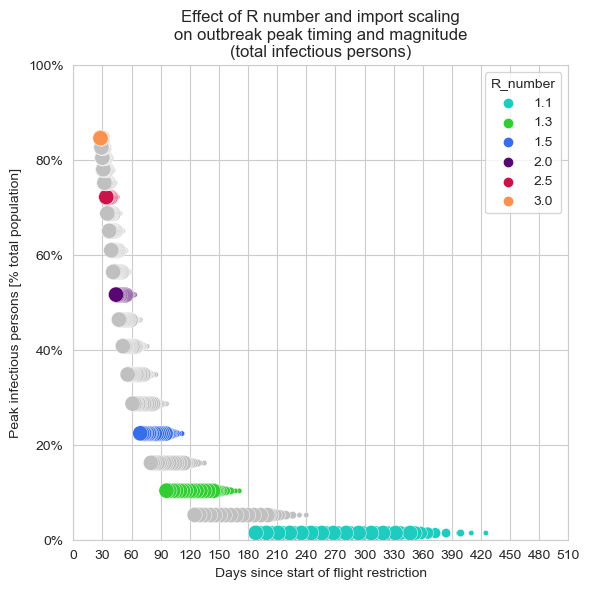

In [11]:
# plot peak sizes here
plot_data = d0_infc2_m.loc[d0_infc2_m['u_REff'] > 1.001, :]
plot_data = plot_data.rename(columns={'u_REff': 'R number',
                                      'u_NominalImports': 'Total Imports'})
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
scaling = 1
# plot_sizes = {5: scaling,  # in pt
#               10: 2 * scaling,
#               15: 3 * scaling,
#               20: 4 * scaling}

plot_sizes = {imp: scaling * imp for imp in plot_data['Total Imports'].unique()}
fig2, ax2 = plt.subplots(figsize=(6, 6))
plot2_peaks = sns.scatterplot(plot_data, x='max_day', y='max', hue='R number',
                              size='Total Imports', sizes=plot_sizes,
                              ax=ax2, palette=palette_s2)

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{int(x * 100)}%")
ax2.set_ylim(0,1)
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_xticks(ticks=(range(0, 511, 30)))
ax2.set_ylabel('Peak infectious persons [% total population]')
ax2.set_xlabel('Days since start of flight restriction')
ax2.set_title('Effect of R number and import scaling\n'
              'on outbreak peak timing and magnitude\n'
              '(total infectious persons)')

handles, labels = ax2.get_legend_handles_labels()
items = [1, 3, 5, 10, 15, 20]  # indices. hardcoded.
handles_plt, labels_plt = zip(*[(handles[idx], labels[idx]) for idx in items])
# labels_plt = [labels[idx] for idx in [0,2]]
ax2.legend(handles=handles_plt, labels=labels_plt, title='R_number')

plt.tight_layout()
fig2.savefig(f'output_figures/plot_sens_peak_timing, {model_vers}.jpg', dpi=300)
del fig2, ax2

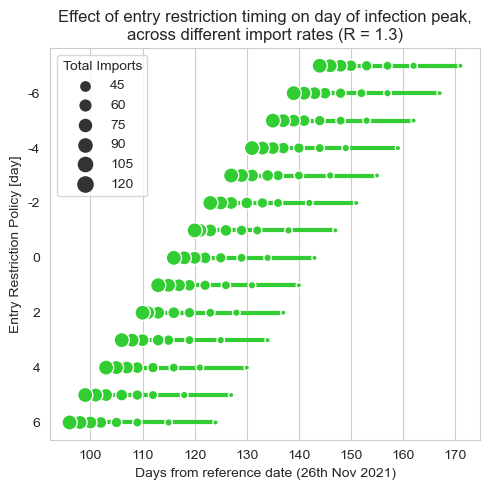

In [12]:

# specific plot for nominal case
plot_ref = 1.3
plot_data = d0_infc2_m.loc[d0_infc2_m['u_REff'] == plot_ref, :].copy()
plot_data['max'] = plot_data['max'] / exps_s.c_pop_total
rn = {'p_FlightBans': 'Entry Restriction Policy [day]',
      'u_NominalImports': 'Total Imports'}
plot_data = plot_data.rename(columns=rn)
fig3, ax3 = plt.subplots(figsize=(5, 5))
palette = 'cet_CET_R3'
# 'blueviolet' reference
palette_2 = dict((k,'limegreen') for k in policy_inputs.values() )
f3_line = sns.lineplot(plot_data, x='max_day', y=rn['p_FlightBans'],
                       hue=rn['p_FlightBans'], palette=palette_2, ax=ax3, legend=False, linewidth=3, zorder=0.9)
f3_scatter = sns.scatterplot(plot_data, x='max_day', y=rn['p_FlightBans'], hue=rn['p_FlightBans'],
                             size=rn['u_NominalImports'],
                             palette=palette_2,
                             ax=ax3, edgecolor='white', linewidth=1,
                             legend=True, sizes=plot_sizes)

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{int(x - exps_s.c_nominal_ref_date)}")
ax3.yaxis.set_major_formatter(ticks_y)
ax3.invert_yaxis()
ax3.yaxis.grid(False)

# ax3.set_xticks(range(65, 101, 5))
ax3.set_xlabel('Days from reference date (26th Nov 2021)')

ax3.set_title('Effect of entry restriction timing '
              'on day of infection peak,\n'
              'across different import rates '
              f'(R = {plot_ref})')

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles[-6:], labels=labels[-6:], title='Total Imports')

plt.tight_layout()
fig3.savefig(f'output_figures/plot_sens, effect of policy on infection peak, zoom nominal, {model_vers}, {plot_ref}.jpg', dpi=300)

del ax3, fig3

# Sensitivity: plot: deltas

In [13]:
# group by R0 and nominal import scaling, trying to get the difference in TDD (time delta difference).
# TDD describes the gain in days you get from having an earlier flight ban
infc2_m_group = d0_infc2_m.groupby(by=['u_REff', 'u_NominalImports'], axis=0, group_keys=True)
temp_dict = {}
metric = 'start_50000'

# isolate the start time of the outbreak
for i, cat in enumerate(infc2_m_group):
    name, group = cat
    t_first = group[metric].min()
    t_last = group[metric].max()
    t_range = t_last - t_first

    t_day_deltas = group[metric].diff(periods=-1)
    tdd_avg = t_day_deltas.mean()
    tdd_max = t_day_deltas.max()
    tdd_min = t_day_deltas.min()
    tdd_range = tdd_max - tdd_min

    temp_dict[i] = {
        'r0' : name[0],
        'import' : name[1],
        't_first': t_first,
        't_last': t_last,
        't_range': t_last - t_first,
        'tdd_max' : tdd_max,
        'tdd_min': tdd_min,
        'tdd_avg' : tdd_avg,
        'tdd_range': tdd_range,

    }

what_df = pd.DataFrame.from_dict(temp_dict, orient='index')
del temp_dict, metric, i, cat, name, group, t_first, t_last, t_range, t_day_deltas, tdd_min, tdd_max, tdd_avg, tdd_range

Text(0.5, 0, 'Days since nominal')

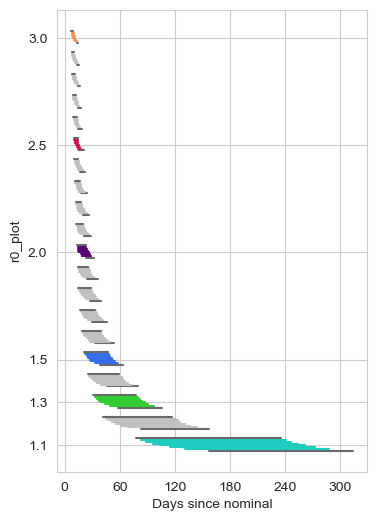

In [14]:
# we know that the t_range, tdd_avg, and tdd_range are the same across R0
# the effect of importation is seen to only affect peak timing
# however, the efficacy of the flight bans over longer durations is not visible, due to the short range of flight bans
# how about difference of period between
what_df['r0_plot'] = what_df.r0 + ((what_df['import'] // 15 - 4) / 120)
what_df['category'] = [str(i) for i in list(zip(what_df['r0'], what_df['import']))]

# massage common palette for plotting
wdf_color_diff = list(zip(what_df['r0'], what_df['import'], what_df['category']))
# create redundant palette
wdf_palette = {}
wdf_makeblack = [15,120]
for r0, imp, cat in wdf_color_diff:
    if imp in wdf_makeblack:
        wdf_palette[cat] = 'dimgray'
    else:
        wdf_palette[cat] = palette_s2[r0]

what_df_melt = what_df.melt(id_vars=['r0_plot', 'r0', 'import', 'category'], value_vars=['t_first','t_last'])
fig, ax = plt.subplots(figsize=(4,6))
sns.lineplot(data=what_df_melt, x='value', y='r0_plot', hue='category', palette=wdf_palette, ax=ax, legend=False)

ax.set_yticks(s_R_highlight_all)
ax.set_xticks(range(0, 301, 60))
ax.set_xlabel('Days since nominal')

In [15]:
# make heatmap (due to large disparity in t_range)
# we isolate for 5 scenarios: 1.1, 1.5, 2.0, 2.5, 3.0
# look at t_range and tdd
# r_range = [1.1, 1.5, 2., 2.5, 3.]
# what_df_specific = what_df[what_df['r0'].isin(r_range)]
# try plotting the TDDs

# create redundant palette
wdf_palette = {}
wdf_makeblack = []
for r0, imp, cat in wdf_color_diff:
    if imp in wdf_makeblack:
        wdf_palette[cat] = 'dimgray'
    else:
        wdf_palette[cat] = palette_s2[r0]


In [16]:
# clean up data for histogram/heatmap
wdf2 = what_df.groupby(by=['r0'], group_keys=True)
temp_dict = {}

# get difference vs next import state
# we know that the t_range stays almost constant
for i, cat in enumerate(wdf2):




# fig, ax = plt.subplots(figsize=(6,6))
# sns.scatterplot(what_df, x='tdd_avg',
#                 y='r0',
#                 hue='category',
#                 palette=wdf_palette,
#                 legend=False,
#                 linewidths=0.,
#                 alpha=0.5,
#                 ax=ax)
# ax.set_yticks(s_R_highlight_all)
# ax.set_xticks(range())


SyntaxError: incomplete input (2520939378.py, line 23)

# Policies: post-processing

In [ ]:
#  now look at dataset for flightbans
results_p: pd.DataFrame = post.add_extra_metrics(exp_obj=exps_p)
meta_p = pd.DataFrame.from_dict(exps_p.results_metadata, orient='index')
policies_p = dict((v, k) for k, v in exps_p.p_flightbans_map.items())

p_piv_inf_current = results_p.pivot(values='infected_total', index='elapsed_nominal', columns='exp_id')
p1_inf_cum = results_p.pivot(values='cum_infected_pct', index='elapsed_nominal', columns='exp_id')

In [ ]:
p2_inf_current = post.add_threshold_time_search(df_to_search=p_piv_inf_current,
                                                df_to_add=meta_p,
                                                threshold=5000)
p2_inf_current['duration_5k_to_peak'] = p2_inf_current['max_day'] - p2_inf_current['start_5000']
p2_inf_current['max_pct']  = p2_inf_current['max'] / exps_p.c_pop_total
p2_inf_current['p_FlightBans_rel'] = p2_inf_current['p_FlightBans'].map(exps_p.p_flightbans_map)  #.astype(pd.Int64Dtype())

p3_inf_current = pd.melt(p2_inf_current,
                         id_vars=['u_REff','p_FlightBans'],
                         value_vars=['duration_5000','start_5000','end_5000','max_day','duration_5k_to_peak'],
                         value_name='y')



In [ ]:
p2_inf_current['max_day'] - p2_inf_current['start_5000']

In [ ]:
fig9, ax9 = plt.subplots(figsize=(6,6))
plot_data = results_p.copy()
plot_data['infected_total_pct'] = plot_data['infected_total'] / exps_p.c_pop_total
palette = 'cet_CET_R3'
sns.lineplot(data=plot_data, x='elapsed_nominal', y='infected_total_pct',
             palette=palette, hue='p_FlightBans', linewidth=4.5, ax=ax9, legend=True)
ax9.set_xlabel('Days since reference day (26 Nov 2021)')
ax9.set_ylabel('Percentage of population currently infectious')
ax9.set_title('Effect of entry restriction policy on outbreak timeline')

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{int(x * 100)}%")
ax9.yaxis.set_major_formatter(ticks_y)

# h, l = ax9.get_legend_handles_labels()
ax9.legend(title='Flight Ban')
ax9.set_xticks(range(-30, 211, 15))
ax9.set_xlim(-17, 120)
plt.tight_layout()
fig9.savefig(f'output_figures/plot_policies, effect of policy on outbreak timeline first, {model_vers}.jpg', dpi=300)


# Policies: plot relationship of entry restrictions on milestone day

In [ ]:
# x = flight ban day, y = start day/ max day (doesn't matter?)
# might as well add the delta graph as sanity check
plot_data = pd.melt(p2_inf_current, id_vars=['p_FlightBans'],
                    value_vars=['start_5000','end_5000', 'max_day'])
plot_data['p_FlightBans'] = plot_data['p_FlightBans'] - exps_p.c_nominal_ref_date
fig5, ax5 = plt.subplots(figsize=(5,5))
palette_p5 = cmr.get_sub_cmap('viridis_r', start=0., stop=1, N=3)
sns.lineplot(data=plot_data, y='p_FlightBans', x='value',
             hue='variable', ax=ax5,
             palette=palette_p5.colors, hue_order=['start_5000','max_day','end_5000'],
             estimator=None, orient='y', linewidth=3)  # these two params were problematic!

# ticks_y = ticker.FuncFormatter(lambda x, pos: f'{}')

ax5.axhline(y=0, color='tab:blue', zorder=0.9)
ax5.set_xlabel('Day since reference date (26 Nov 2021)')
ax5.set_xticks(ticks=range(0, 151, 15))  # was in stops of 30
ax5.set_yticks(ticks=range(-10, 61, 5))
ax5.set_xlim(None, 120)  # Temp
h, l = ax5.get_legend_handles_labels()
ax5.legend(handles=h, labels=['Start', 'Peak', 'End'], title='Outbreak\nphase')

ax5.set_ylabel('Entry restriction policy day')
ax5.set_title('Effect of entry restriction day on outbreak period')
ax5.invert_yaxis()
plt.tight_layout()
fig5.savefig(f'output_figures/plot_policies, effect of policy on outbreak period, wave, {model_vers}.jpg', dpi=300)

# Policies: plot duration/peak/

In [ ]:
fig7, ax7 = plt.subplots(figsize=(4,4))
sns.scatterplot(p2_inf_current, x='p_FlightBans_rel', y='max_pct', ax=ax7)

ticks_y = ticker.FuncFormatter(lambda x, pos: f"{round(x * 100,3)}%")
ax7.yaxis.set_major_formatter(ticks_y)
fig7.savefig(f'output_figures/plot_policy, effect of policy on outbreak peak, {model_vers}.jpg', dpi=300)

# Policies: plot outbreak trajectory (cumulative infections)

In [ ]:
# make custom cmap for plots with obscured values
p_cats = exps_p.p_flightbans_map  # should be machine days (not relative)
# p6_norm = TwoSlopeNorm(vcenter=exps_p.c_nominal_ref_date)

# points to highlight
p_f6_highlight = [k for k, v in p_cats.items() if (v%7 == 0) and (v <= 28)]
# p_f5_ref_colour = {0: }

p_f6_ref = {exps_p.c_nominal_ref_date: 'deepskyblue'}  # was 'limegreen'
p_f6_dull = 'silver'
p_f6_highlight_c = cmr.get_sub_cmap('cet_bmy', start=0.2, stop=0.9, N=len(p_f6_highlight))
# p_f6_c = dict((k, p_f6_dull) for k in p_cats.keys())
# p_f6_c.update(dict(zip(p_f6_highlight, p_f6_highlight_c.colors)))
p_f6_c = dict(zip(p_f6_highlight, p_f6_highlight_c.colors))
p_f6_c.update(p_f6_ref)

p_f6_plt_order = p_f6_highlight + [exps_p.c_nominal_ref_date]
# p_f6_plt_order = list(set(p_cats.keys()) - set(p_f6_plt_order)) + p_f6_plt_order
# dict(zip(p_f6_highlight, p_f6_highlight_c.colors))

In [ ]:
plot_data = results_p.loc[results_p['p_FlightBans'].isin(p_f6_c.keys()),:]

fig6, ax6 = plt.subplots(figsize=(5.5,5))
sns.lineplot(data=plot_data, x='elapsed_nominal', y='cum_infected',
             hue='p_FlightBans', palette=p_f6_c, hue_order=p_f6_plt_order, ax=ax6)

h, l = ax6.get_legend_handles_labels()
ax6.legend(handles=h, labels=[p_cats[int(n)]//7 for n in l], title='Entry\nRestriction\n[week]')
ax6.set_ylabel('Cumulative infections')
ax6.set_xlabel('Days since reference date (26 Nov 2021)')
# ax6.set_xticks(range(-15, 151, 15))
ax6.set_xticks(range(-10, 31, 2))
ax6.set_ylim(0., 10000)
ax6.set_xlim(-10, 30)
# ticks_y = ticker.FuncFormatter(lambda x, pos: f"{round(x*100, 1)}%")
# ax6.yaxis.set_major_formatter(ticks_y)
ax6.set_title('Effect of variable entry restriction on outbreak trajectory')
ax6.axvline(x=0, color='dimgray',zorder=0.9)
# only collect legend items that need to be highlighted

plt.tight_layout()
# NOTE: changed name!
fig6.savefig(f'output_figures/plot_policy, effect of policy on outbreak trajectory, alt {model_vers}.jpg', dpi=300)

# Policies: plot outbreak early development

# Importation, Omicron Prevalence graph

In [ ]:
# make plot for importation shape

prevalence_df = pd.read_pickle('data_input/omi_prevalence_flights_not_inflated.pickletable')
# add a x-axis item for relative days and plot shape
prevalence_df['day_relative'] = prevalence_df.index - exps_s.c_nominal_ref_date

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(prevalence_df, x='day_relative', y='prevalence', ax=ax, linewidth=3.)

ax.set_xlabel('Days relative to reference day (26 Nov 2021)')
ax.set_title("Omicron prevalence in SA")
ax.set_ylabel('Prevalence in SA [%]')
ticks_y = ticker.FuncFormatter(lambda x, pos: f'{x * 100}')
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticks(ticks=range(-15, 61, 15))
# ax.set_xticks(ticks=range(0,61,30))
ax.axvline(x=0, color='darkorange', linewidth=2, zorder=0.9)

plt.tight_layout()
fig.savefig('output_figures/plot_prevalence.jpg', dpi=300)



# Importation: Imports per day (after scaling)


In [ ]:
# take the results_p stuff

imports_p = results_p.pivot(values='imported', index='day',columns='p_FlightBans_rel').sum(axis=0)

In [ ]:
fig8, ax8 = plt.subplots(figsize=(5,5))

sns.lineplot(x=imports_p.index,
             y=imports_p,
             ax=ax8, linewidth=3)
ax8.set_ylabel('Total number of imported cases (per scenario)')
ax8.set_xlabel('Entry restriction policy [day]')
ax8.set_title('Effect of entry restriction policy on\n'
              'number of total imported cases\n'
              '(scaling: 15 pax on reference date)')

# ax8.axvline(x=0, color='darkorange')
# ax8.set_xticks(range(-15, 51, 15))

plt.tight_layout()
ax8.axvline(x=0, color='darkorange')
ax8.set_xticks(range(-15, 51, 15))
fig8.savefig(f'output_figures/plot_imports, effect of policy on total imports, large, {model_vers}.jpg', dpi=300)
ax8.set_xlim(-7,0)
ax8.set_ylim(0,50)
ax8.set_xticks(range(-7,1,1))
plt.tight_layout()
fig8.savefig(f'output_figures/plot_imports, effect of policy on total imports, zoomed, {model_vers }.jpg', dpi=300)
# ax8.set_xlim(None,None)
# ax8.set_ylim(None, None)


# Older code: cold storage

In [ ]:
# TODO: note that argument N in the following function calls are hardcoded
palette_sub1 = cmr.get_sub_cmap('cmr.guppy_r', start=0.1, stop=0.9, N=3)  # (-2 to 2)
palette_sub2 = cmr.get_sub_cmap('YlOrRd', start=0.4, stop=0.9, N=3)  # 7 to 56
palette_sub3 = tuple(n / 255 for n in (59, 171, 62))
plot_palette = palette_sub1.colors + palette_sub2.colors + [palette_sub3]
palette_sub2

In [ ]:
# function definition for plotting

def sns_lineplot_convenience(*,  # asterisk = must specify non-default variables
                             y,
                             data=results_s,
                             x='day_relative',
                             hue='flightban_day',
                             palette=plot_palette,
                             hue_order=flightbans,
                             legend='full',
                             linewidth=1.7,
                             **kwargs
                             ):
    # the locals() method may not work due to namespaces
    inputs = locals().copy()  # note copy() maybe redundant
    inputs.pop('kwargs')
    return sns.lineplot(**inputs, **kwargs)


def savefig_conv(
        save_path,
        yes_save=True,
        dpi=300
):
    if yes_save:
        plt.savefig(save_path, dpi=dpi)



In [ ]:
# colour handling
save_plot = True
fig_line_log = sns_lineplot_convenience(y='infected_new')
plt.axvline(x=0., zorder=0.9, color='darkgrey', linewidth=2)  # reference line for nominal day (26th Nov)
# plt.axhline(y=1e4, zorder=0.9, color='pink', linewidth=2)
plt.legend(title='Flight ban\nimplemented\n[day]')
plt.title('Newly infected cases, log scale\n[R = 1.3 over 3 days]')
plt.ylabel('New daily infections [persons]')
plt.xlabel('Days since nominal date (26th Nov 2021)')
plt.title('Newly infected cases, linear scale\n[R = 1.3 over 3 days]')
if save_plot:
    plt.savefig('output_figures/infected_new, linear, model v0.jpg', dpi=300)

plt.yscale(value='log')
plt.ylim(1, 10e5)
plt.title('Newly infected cases, log scale\n[R = 1.3 over 3 days]')
if save_plot:
    plt.savefig('output_figures/infected_new, log, model v0.jpg', dpi=300)

# # TODO: get metric for days till 10k (relative to reference date, or total start?)
# TODO: effect of shifting R (is R the slope of the log curve)
# TODO: get the day diff, perhaps see if there's a mathematical relationship
# TODO: make supplement plot for importation
# TODO: look at delta for log slope (x=30), what is the given slope
# TODO: another metric for 'cumulative infections' -> defined to be sum of 'current infectious' and 'isolated'

In [ ]:
# plot importation graph
save_plot = True
f, ax = plt.subplots(figsize=(6, 3))
temp_wo_zero = results_s[results_s['imported'] > 0.]
fig_import = sns_lineplot_convenience(y='imported',
                                      data=temp_wo_zero, hue_order=list(reversed(flightbans)),
                                      palette=list(reversed(plot_palette)),
                                      linewidth=4)

# plot reference lines
for d, c in zip(flightbans, plot_palette):
    plt.axvline(x=d - 1, color=c, alpha=0.7, linewidth=1.5, zorder=0.6)

plt.grid(visible=False, which='both', axis='x')
plt.xlim((None, 60))
plt.xlabel('Days since nominal date (26th Nov 2021)')
plt.ylabel('New imported cases [person]')
plt.title("Imported Omicron cases from SA, linear scale")
plt.tight_layout()
savefig_conv('output_figures/imported, linear, model v0.jpg', yes_save=save_plot)
plt.title("Imported Omicron cases from SA, log scale")

plt.ylim(0.001, 100)
plt.yscale('log')

savefig_conv('output_figures/imported, log, model v0.jpg', yes_save=save_plot)


In [ ]:
# days till 10k (new cases)
grp = results_s.groupby(level='flightban_day', group_keys=False)
infect_cumul = {}
infect_new = {}
for b_day, group in grp:
    references = [exps_s.c_nominal_ref_date, b_day]
    infect_cumul[b_day] = [(group['cum_infected'] > 1e5).idxmax()[1] - d for d in references]
    infect_new[b_day] = [(group['infected_new'] > 1e5).idxmax()[1] - d for d in references]

# look at daily delta rates
infected_new = pd.pivot(results_s.reset_index(level='flightban_day'), columns='flightban_day', values='infected_new')



In [ ]:
imports_piv = pd.pivot(results_s.reset_index(level='flightban_day'), columns='flightban_day',
                       values='imported').sum(axis=0)